# 1. Aquisição e transformação dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.metrics import geometric_mean_score

In [2]:
r_wine = pd.read_csv('datasets/winequality-red.csv', sep = ';')

In [3]:
x = r_wine.iloc[:, 0:-1]
y = r_wine.iloc[:, -1]

In [4]:
x

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [5]:
column_name = r_wine.drop(columns=['quality']).columns

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(x)
X=scaler.transform(x)    
pca = PCA()
x_new = pca.fit_transform(x)

def myplot(pcs,loadings, target, column_name, labels=None):
    xs = pcs[:,0]
    ys = pcs[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    pc1 = xs*scalex
    pc2 = ys*scaley

    df = {'pc1': pc1, 'pc2': pc2, 'quality': target}
    df = pd.DataFrame(data=df)

    fig = px.scatter(df, x='pc1', y='pc2', color='quality', color_continuous_scale = "rainbow")

    for i, feature in enumerate(column_name):
        fig.add_shape(type='line',
                      x0=0,
                      y0=0,
                      x1=loadings[i,0],
                      y1=loadings[i,1]
                    )
        fig.add_annotation(x=loadings[i,0],
                           y=loadings[i,1],
                           ax=0,
                           ay=0,
                           xanchor="center",
                           yanchor="bottom",
                           text = feature,
                           font=dict(size=18,
                                     color="crimson"
                                    )
                          )
    fig.show()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, column_name)

In [6]:
from sklearn.preprocessing import scale 
x_reduced = scale(x_new)[:,:7]

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
x_train = np.array(x_train)
x_test = np.array(x_test)

# 2. ADASYN e Undersampling

In [8]:
wg = y_train.value_counts()

In [9]:
for i in range(0, len(wg)):
    if wg[i+3] < 6:
        wg[i+3] = 6

strategy1_w = {3:wg[3], 4:wg[4], 5:wg[5], 6:wg[6], 7:wg[7], 8:wg[8]}
fix = RandomOverSampler(sampling_strategy=strategy1_w)

In [10]:
wg[8] = round(0.15*wg[5])
wg[4] = round(0.2*wg[5])
wg[3] = round(0.1*wg[5])

strategy2_w = {3:wg[3], 4:wg[4], 8:wg[8]}
over = ADASYN(sampling_strategy=strategy2_w)

In [11]:
wg[5] = round(0.5*wg[5])
wg[6] = round(0.6*wg[6])

strategy3_w = {5:wg[5], 6:wg[6]}
under = RandomUnderSampler(sampling_strategy=strategy3_w)

In [12]:
steps = [('f', fix), ('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_train, y_train = pipeline.fit_resample(x_train, y_train)

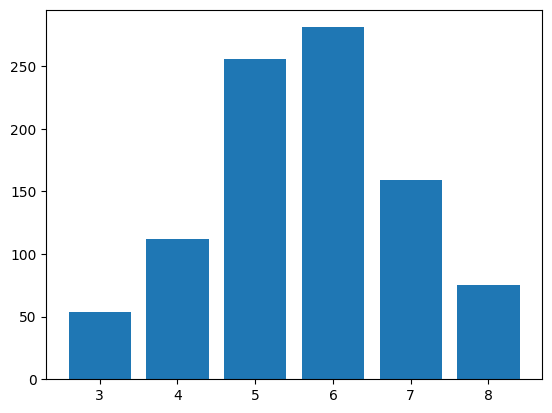

In [13]:
counter = Counter(y_train)
plt.bar(counter.keys(), counter.values())
plt.show()

# 3. Implementação da RNA

## 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [14]:
# Import packages
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, recall_score, f1_score
from bayes_opt import BayesianOptimization
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from scikeras.wrappers import KerasClassifier
from sklearn import metrics
import math

pd.set_option("display.max_columns", None)

2022-11-27 21:37:39.323065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 21:37:39.547456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 21:37:39.547489: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-27 21:37:39.591870: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 21:37:41.013030: W tensorflow/stream_executor/platform/de

In [15]:
score_acc = make_scorer(roc_auc_score)

In [16]:
x_train = np.array(x_train)
x_test = np.array(x_test)


In [17]:
y_train.shape

(937,)

In [18]:
def logistic(w3, w4, w5, w6, w7, w8):

    weights = [w3, w4, w5, w6, w7, w8]

    w = {}
    for i in range(0, len(weights)):
        index = i+3
        w[index] = weights[i]

    lr = LogisticRegression(solver="liblinear", class_weight=w)

    return lr

In [19]:
def evaluate_model(w3, w4, w5, w6, w7, w8):
    
    lr = logistic(w3, w4, w5, w6, w7, w8)

    kf = KFold(n_splits=10, random_state=1, shuffle=True)
    score = []
    
    for train_index, test_index in kf.split(x_train):
        # print("TRAIN:", train_index, "TEST:", test_index)
        xtr, xte = x_train[train_index], x_train[test_index]
        ytr, yte = y_train[train_index], y_train[test_index]

        lr.fit(xtr, ytr)
        y_pred = lr.predict(xte)
        roc = roc_auc_score(yte, lr.predict_proba(xte), multi_class='ovr')
        acc = accuracy_score(yte, y_pred)
        score.append(math.sqrt(acc*roc))

    score = sum(score)/len(score)

    return score

In [20]:
pbounds = {'w3': (0,100),
            'w4': (0,100),
            'w5': (0,100),
            'w6': (0,100),
            'w7': (0,100),
            'w8': (0,100)
            }

optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)

In [21]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

optimizer.maximize(init_points=250, n_iter=200,)

|   iter    |  target   |    w3     |    w4     |    w5     |    w6     |    w7     |    w8     |
-------------------------------------------------------------------------------------------------
| 1         | 0.5365    | 41.7      | 72.03     | 0.01144   | 30.23     | 14.68     | 9.234     |
| 2         | 0.5913    | 18.63     | 34.56     | 39.68     | 53.88     | 41.92     | 68.52     |
| 3         | 0.5322    | 20.45     | 87.81     | 2.739     | 67.05     | 41.73     | 55.87     |
| 4         | 0.5789    | 14.04     | 19.81     | 80.07     | 96.83     | 31.34     | 69.23     |
| 5         | 0.5219    | 87.64     | 89.46     | 8.504     | 3.905     | 16.98     | 87.81     |
| 6         | 0.5765    | 9.835     | 42.11     | 95.79     | 53.32     | 69.19     | 31.55     |
| 7         | 0.5426    | 68.65     | 83.46     | 1.829     | 75.01     | 98.89     | 74.82     |
| 8         | 0.5757    | 28.04     | 78.93     | 10.32     | 44.79     | 90.86     | 29.36     |
| 9         | 0.5214

In [22]:
params_ = optimizer.max['params']
params_

{'w3': 41.86346557037645,
 'w4': 37.169162993584706,
 'w5': 51.05783196961006,
 'w6': 48.69985855098241,
 'w7': 17.05577916192194,
 'w8': 100.0}

In [20]:
# lr = logistic(69.14  , 23.43 ,  25.2  ,  19.64 ,  20.82 ,  79.28)
lr = logistic(params_["w3"], params_["w4"], params_["w5"], params_["w6"], params_["w7"],
                params_["w8"])

lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [21]:
lr.score(x_test, y_test)

0.5075

In [22]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[  0,   0,   2,   0,   0,   0],
       [  2,   1,   7,   4,   0,   0],
       [  5,   6, 120,  36,   1,   1],
       [  0,   5,  55,  71,  21,  18],
       [  0,   1,   3,  11,  10,  15],
       [  0,   0,   0,   2,   2,   1]])

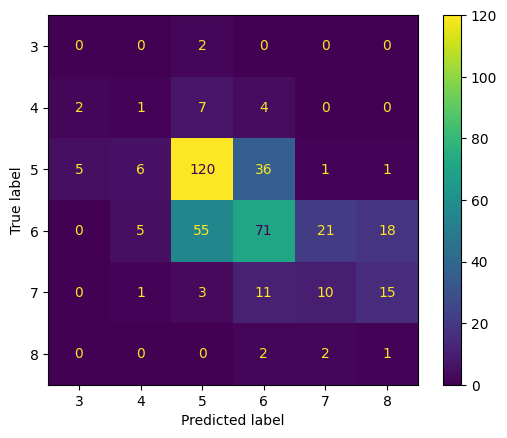

In [25]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [3,4,5,6,7,8])
cm_display.plot()
plt.savefig("Clog_r.png")

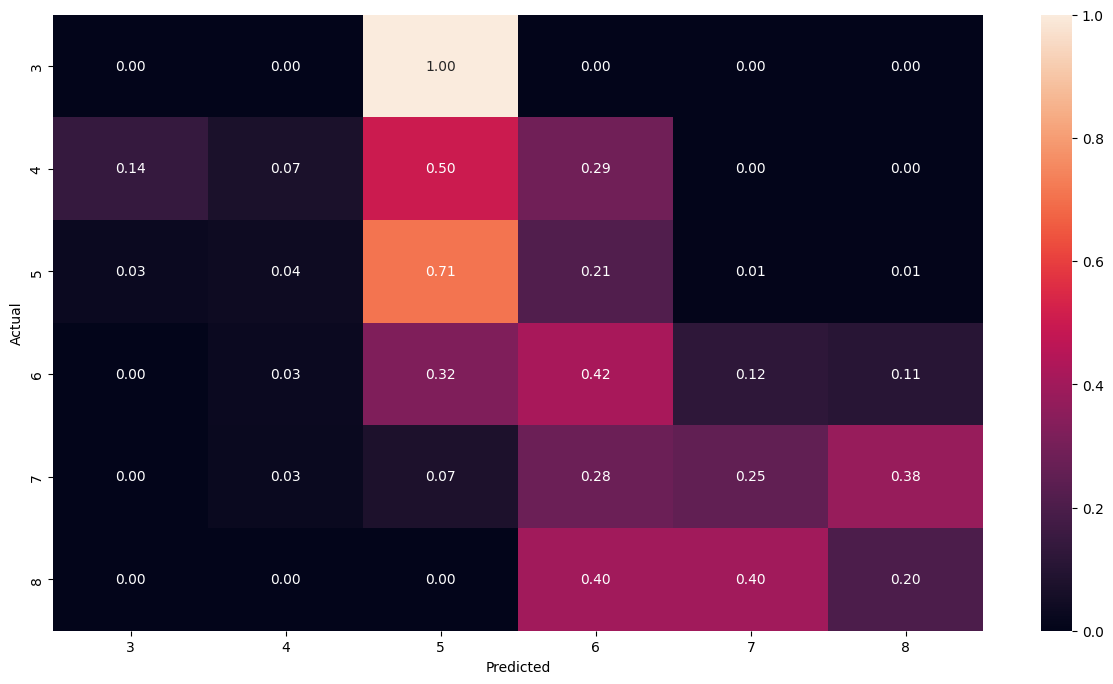

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)